In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("../../data/sample01/application_record.csv", encoding = 'utf-8')
record = pd.read_csv("../../data/sample01/credit_record.csv", encoding = 'utf-8')

In [6]:
print(data.shape)
print(record.shape)

(438557, 18)
(1048575, 3)


In [7]:
data.sort_values(by=['ID'])

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423317,7999660,F,N,N,0,90000.0,State servant,Higher education,Single / not married,House / apartment,-13432,-5446,1,0,0,0,Core staff,1.0
426434,7999696,F,N,Y,2,135000.0,State servant,Secondary / secondary special,Married,House / apartment,-12576,-4382,1,0,0,0,Medicine staff,4.0
432885,7999738,M,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-9970,-119,1,0,0,0,NaN,2.0
421225,7999784,F,Y,Y,1,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-10630,-454,1,0,0,0,NaN,3.0


In [8]:
data.groupby(['ID']).count()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,
5008804,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
5008805,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
5008806,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5008808,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5008809,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999660,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7999696,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7999738,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1


In [9]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [10]:
#agrupar los usuarios y obtener el minimo valor del balance del mes
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month

,MONTHS_BALANCE
ID,
5001711,-3
5001712,-18
5001713,-21
5001714,-14
5001715,-59
...,...
5150482,-28
5150483,-17
5150484,-12


In [11]:
#renombrar la columna
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
begin_month

,begin_month
ID,
5001711,-3
5001712,-18
5001713,-21
5001714,-14
5001715,-59
...,...
5150482,-28
5150483,-17
5150484,-12


In [12]:
#fusionar el dataframe principal con los valores de la columna begin_month
new_data=pd.merge(data,begin_month,how="left",on="ID")

In [13]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


In [14]:
new_data.shape

(438557, 19)

#### Generalmente, los usuarios en riesgo deberían estar en el 3%, por lo que elijo a los usuarios que tienen más de 60 días de retraso como usuarios de riesgo objetivo. Esas muestras están marcadas como '1', de lo contrario, son '0'.

>ID:
                Número de cliente
>MONTHS_BALANCE:
                 El mes de los datos extraídos es el punto de partida, hacia atrás,
>                * 0 es el mes actual,
>                * -1 es el mes anterior, y así sucesivamente
>ESTADO
>                0: 1-29 días de atraso
>                1: 30-59 días de atraso
>                2: 60-89 días de atraso
>                3: 90-119 días de atraso
>                4: 120-149 días de atraso
>                5: Deudas vencidas o incobrables, cancelaciones por más de 150 días
>                C: Pagado ese mes
>                X: sin préstamo durante el mes

In [15]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes'
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes'

In [16]:
record.head()

,ID,MONTHS_BALANCE,STATUS,dep_value
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None


In [17]:
record.tail()

,ID,MONTHS_BALANCE,STATUS,dep_value
1048570,5150487,-25,C,None
1048571,5150487,-26,C,None
1048572,5150487,-27,C,None
1048573,5150487,-28,C,None
1048574,5150487,-29,C,None


In [18]:
# contar los valores dep_value agrupados por ID
cpunt=record.groupby('ID').count()
cpunt.head()

,MONTHS_BALANCE,STATUS,dep_value
ID,,,
5001711,4,4,0
5001712,19,19,0
5001713,22,22,0
5001714,15,15,0
5001715,60,60,0


In [19]:
# Yes -> los clientes que tienen mas de 60 dias de retraso
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'

In [20]:
cpunt.head()

,MONTHS_BALANCE,STATUS,dep_value
ID,,,
5001711,4,4,No
5001712,19,19,No
5001713,22,22,No
5001714,15,15,No
5001715,60,60,No


In [21]:
cpunt.tail()

,MONTHS_BALANCE,STATUS,dep_value
ID,,,
5150482,18,18,No
5150483,18,18,No
5150484,13,13,No
5150485,2,2,No
5150487,30,30,No


In [22]:
cpunt = cpunt[['dep_value']]

In [23]:
cpunt.head()

,dep_value
ID,
5001711,No
5001712,No
5001713,No
5001714,No
5001715,No


In [24]:
cpunt.shape

(45985, 1)

In [25]:
# fusionar new_data con dep_value (variable a predecir)
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')

In [26]:
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,No
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,No
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No


In [27]:
new_data.shape

(36457, 20)

In [28]:
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [29]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


In [30]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

#### Features

In [31]:
#renombrar columnas
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [32]:
new_data.head()

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-15.0,No,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-14.0,No,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0


## Identificar y manejar valores

In [33]:
#crear dataframe con valores booleanos para validar los missing value
missing_data = new_data.isnull()


In [35]:
# validamos los missing value para todas las columnas excepto el ID
for column in missing_data.columns.values.tolist():
    if column != 'ID':
        print(column)
        print (missing_data[column].value_counts())
        print("")

Gender
False    36457
Name: Gender, dtype: int64

Car
False    36457
Name: Car, dtype: int64

Reality
False    36457
Name: Reality, dtype: int64

ChldNo
False    36457
Name: ChldNo, dtype: int64

inc
False    36457
Name: inc, dtype: int64

inctp
False    36457
Name: inctp, dtype: int64

edutp
False    36457
Name: edutp, dtype: int64

famtp
False    36457
Name: famtp, dtype: int64

houtp
False    36457
Name: houtp, dtype: int64

DAYS_BIRTH
False    36457
Name: DAYS_BIRTH, dtype: int64

DAYS_EMPLOYED
False    36457
Name: DAYS_EMPLOYED, dtype: int64

FLAG_MOBIL
False    36457
Name: FLAG_MOBIL, dtype: int64

wkphone
False    36457
Name: wkphone, dtype: int64

phone
False    36457
Name: phone, dtype: int64

email
False    36457
Name: email, dtype: int64

occyp
False    25134
True     11323
Name: occyp, dtype: int64

famsize
False    36457
Name: famsize, dtype: int64

begin_month
False    36457
Name: begin_month, dtype: int64

dep_value
False    36457
Name: dep_value, dtype: int64

target
Fa

In [36]:
# numero de usuarios por ocupacion
new_data.groupby(["occyp"])['ID'].count().sort_values(ascending = False)

occyp
Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: ID, dtype: int64

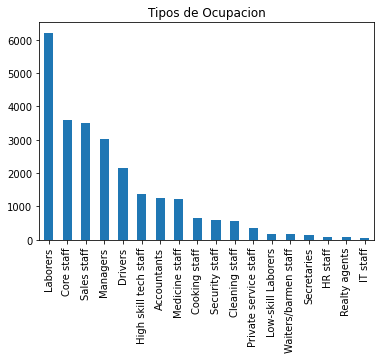

In [37]:
#numero de usuarios por ocupacion# promedio de sueldos anuales por ocupacion (verificar relacion directa)
plot = new_data['occyp'].value_counts().plot(kind='bar',title='Tipos de Ocupacion')

In [38]:
new_data.groupby(["occyp"])['inc'].mean().sort_values(ascending = False)

occyp
Managers                 279117.292829
Realty agents            247500.000000
Drivers                  209797.240412
Accountants              202463.865834
IT staff                 199860.000000
Private service staff    198863.372093
High skill tech staff    196053.579176
HR staff                 193764.705882
Core staff               190172.786967
Laborers                 179794.282402
Security staff           177037.753378
Sales staff              174984.897848
Secretaries              168079.470199
Medicine staff           166114.618061
Waiters/barmen staff     156206.896552
Cleaning staff           149141.107078
Cooking staff            146517.251908
Low-skill Laborers       133920.000000
Name: inc, dtype: float64

opcion 1:
Proceso que recorra todas las filas, al encontrar un ocupacion=NaN, verificar en que rango de sueldo se encuentra para asignarle un ocupacion de acuerdo a sus ingresos anuales
opcion 2:
Eliminar las columnas o filas que contengan NaN

In [39]:
# resguardamos la data hasta este punto# opcion 2, eliminar valores perdidos
df_bkp=new_data

In [40]:
# opcion 2, eliminar valores perdidos
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()


In [41]:
# verificamos la dimension del dataset
new_data.shape

(25134, 21)

In [42]:
new_data.head()

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0


analizando datos

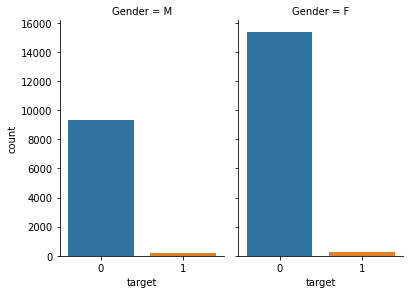

In [44]:
# numero de aprobados por genero
g = sns.catplot(x="target",col="Gender",
                data=new_data, kind="count",
                height=4, aspect=0.7);

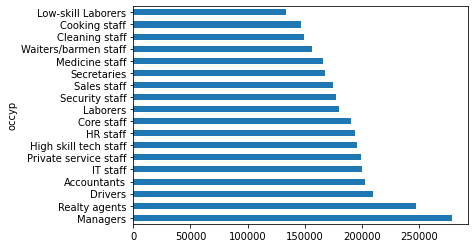

In [45]:
# grafico de los promedios de sueldos por ocupacion
a=new_data.groupby(["occyp"])['inc'].mean().sort_values(ascending = False).plot(kind='barh')

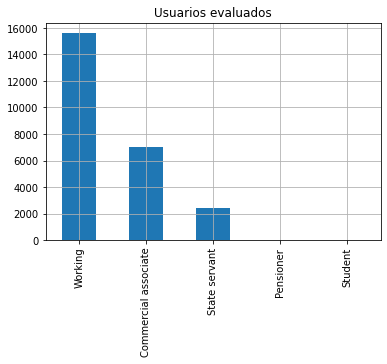

In [46]:
plot = new_data['inctp'].value_counts().plot(kind='bar', title='Usuarios evaluados')
plot.grid()

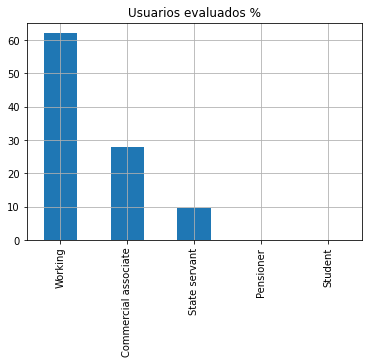

In [47]:
plot = (100 * new_data['inctp'].value_counts() / len(new_data['inctp'])).plot(
kind='bar', title='Usuarios evaluados %')
plot.grid()

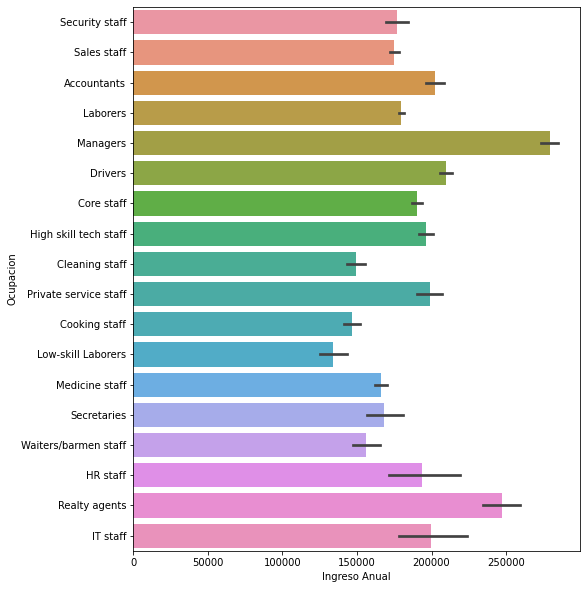

In [48]:
# Ingresos anuales por Ocupacion
plt.figure(figsize=(8,10))
sns.barplot(x=new_data['inc'], y= new_data['occyp'])
plt.ylabel('Ocupacion')
plt.xlabel('Ingreso Anual')
plt.show()

#### Relacionando variables categóricas

In [53]:
# Tabla de contingencia ingreso anuales / ocupacion
pd.crosstab(index=new_data['occyp'],
            columns=new_data['inc'], margins=True)

inc,27000.0,31500.0,32400.0,36000.0,36900.0,40500.0,45000.0,47250.0,49500.0,51750.0,...,765000.0,787500.0,810000.0,900000.0,945000.0,990000.0,1125000.0,1350000.0,1575000.0,All
occyp,,,,,,,,,,,,,,,,,,,,,
Accountants,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1241
Cleaning staff,0,8,0,1,0,9,8,0,2,1,...,0,0,0,0,0,0,0,0,0,551
Cooking staff,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,655
Core staff,0,0,0,2,0,0,16,0,0,0,...,0,0,0,6,0,4,0,0,0,3591
Drivers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2138
HR staff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,85
High skill tech staff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,1383
IT staff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,60
Laborers,0,0,0,2,2,0,6,1,1,0,...,0,0,2,1,0,0,0,0,0,6211


In [54]:
# tabla de contingencia en porcentajes relativos total
pd.crosstab(index=new_data['occyp'], columns=new_data['inc'],
            margins=True).apply(lambda r: r/len(new_data) *100,
                                axis=1)

inc,27000.0,31500.0,32400.0,36000.0,36900.0,40500.0,45000.0,47250.0,49500.0,51750.0,...,765000.0,787500.0,810000.0,900000.0,945000.0,990000.0,1125000.0,1350000.0,1575000.0,All
occyp,,,,,,,,,,,,,,,,,,,,,
Accountants,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011936,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.937535
Cleaning staff,0.000000,0.031829,0.000000,0.003979,0.000000,0.035808,0.031829,0.000000,0.007957,0.003979,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.192250
Cooking staff,0.000000,0.000000,0.000000,0.000000,0.000000,0.015915,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.606032
Core staff,0.000000,0.000000,0.000000,0.007957,0.000000,0.000000,0.063659,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023872,0.000000,0.015915,0.000000,0.000000,0.000000,14.287419
Drivers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003979,0.000000,0.000000,0.000000,0.000000,0.000000,8.506406
HR staff,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.338187
High skill tech staff,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023872,0.000000,0.000000,0.000000,0.000000,0.000000,5.502507
IT staff,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238720
Laborers,0.000000,0.000000,0.000000,0.007957,0.007957,0.000000,0.023872,0.003979,0.003979,0.000000,...,0.000000,0.000000,0.007957,0.003979,0.000000,0.000000,0.000000,0.000000,0.000000,24.711546


<AxesSubplot:xlabel='dep_value', ylabel='inc'>

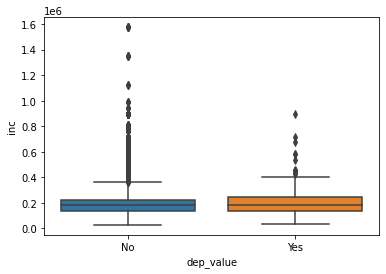

In [56]:
# Categorical variables
sns.boxplot(x="dep_value", y="inc", data=new_data)

#### Veamos que las distribuciones de dep_value e ingresos anuales entre las diferentes categorías de dep_value no tienen una superposición significativa.


### Formato correcto de los datos

In [57]:
new_data.dtypes

ID                 int64
Gender            object
Car               object
Reality           object
ChldNo             int64
inc              float64
inctp             object
edutp             object
famtp             object
houtp             object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
wkphone            int64
phone              int64
email              int64
occyp             object
famsize          float64
begin_month      float64
dep_value         object
target            object
dtype: object

In [58]:
#new_data['Gender']=new_data['dep_value']
new_data.loc[new_data['Gender']=='Yes','target']=1
new_data.loc[new_data['Gender']=='No','target']=0

In [59]:
# tabla de contingencia en porcentajes relativos total
pd.crosstab(index=new_data['dep_value'], columns=new_data['inc'],
            margins=True).apply(lambda r: r/len(new_data) *100,
                                axis=1)

inc,27000.0,31500.0,32400.0,36000.0,36900.0,40500.0,45000.0,47250.0,49500.0,51750.0,...,765000.0,787500.0,810000.0,900000.0,945000.0,990000.0,1125000.0,1350000.0,1575000.0,All
dep_value,,,,,,,,,,,,,,,,,,,,,
No,0.011936,0.031829,0.019893,0.015915,0.007957,0.051723,0.242699,0.003979,0.031829,0.003979,...,0.035808,0.019893,0.031829,0.147211,0.015915,0.015915,0.011936,0.023872,0.031829,98.320999
Yes,0.000000,0.000000,0.000000,0.003979,0.000000,0.000000,0.003979,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003979,0.000000,0.000000,0.000000,0.000000,0.000000,1.679001
All,0.011936,0.031829,0.019893,0.019893,0.007957,0.051723,0.246678,0.003979,0.031829,0.003979,...,0.035808,0.019893,0.031829,0.151190,0.015915,0.015915,0.011936,0.023872,0.031829,100.000000
